In [29]:
import sys

sys.path.insert(0, 'C:/Users/igorl/CMF/reporting-forecasting')

from tqdm import tqdm
from functions.read_table import read_table
import os
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

def load_data(dir):
    df = pd.concat([read_table(os.path.join(dir, file), file)
                    for file in tqdm(os.listdir(dir))])

    company_names = df['Company_name'].copy()
    df.columns = ['{}_{}'.format(col, i) for i, col in enumerate(df.columns)]
    df = df[df.columns[df.nunique(dropna=False) > 1]]
    df = df.apply(pd.to_numeric, errors='coerce')
    df.iloc[:, -1] = company_names
    return df


train_dir = '../data/oil_gas_train/'
df = load_data(train_dir)

df['month'] = pd.Series(df.index, dtype='datetime64[ns]').dt.month.values
df['month_sin'] = np.sin(2 * np.pi * df['month']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12.0)

df.index = pd.Series(df.index.astype('str').str[:10], dtype='datetime64[ns]')
df = df.sort_index()
df = df.loc['2011-03-31':, :]

100%|██████████| 54/54 [00:08<00:00,  6.22it/s]
C:\Users\igorl\AppData\Local\Temp\ipykernel_26548\1395708031.py:35: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df['month'] = pd.Series(df.index, dtype='datetime64[ns]').dt.month.values


In [30]:
from forex_python.converter import CurrencyRates

c = CurrencyRates()

def func(dt):
    r = c.get_rate('USD', 'RUB', dt)
    return r

df['index'] = df.index
df['currency_rate'] = df.apply(lambda x: func(x['index'].date()), axis=1)
reserved = df['currency_rate'].copy()

In [34]:
import requests

def checkindicator(url):
    r = requests.get(url)
    r = r.json()
    periods = r['series']['docs'][0]['period']
    values = r['series']['docs'][0]['value']
    dataset = r['series']['docs'][0]['dataset_name']
    indicators = pd.DataFrame(values, index=periods)
    indicators.columns = [dataset]
    indicators.index = pd.to_datetime(indicators.index)
    return indicators


In [35]:
interest = checkindicator(
    'https://api.db.nomics.world/v22/series/Eurostat/ei_mfir_m/M.NSA.NAP.MF-LTGBY-RT.EU28?observations=1')
euro_yields_10y = checkindicator(
    'https://api.db.nomics.world/v22/series/Eurostat/irt_euryld_m/M.EA.INS_FWD.CGB_EA.Y10?observations=1')
unemployment = checkindicator(
    'https://api.db.nomics.world/v22/series/Eurostat/une_rt_m/M.NSA.TOTAL.PC_ACT.T.EA19?observations=1')
interest = checkindicator(
    'https://api.db.nomics.world/v22/series/Eurostat/ei_mfir_m/M.NSA.NAP.MF-LTGBY-RT.EU28?observations=1')
monthly_change_retail_trade = checkindicator(
    'https://api.db.nomics.world/v22/series/Eurostat/sts_trtu_m/M.TOVT.G47.CA.PCH_SM.EA19?observations=1')


In [36]:
custom_features = [interest, euro_yields_10y, unemployment, monthly_change_retail_trade]

In [37]:
df = df[df.index < '2020-03-01']

In [38]:
for date in df.index.unique():
    date_2 = date - pd.DateOffset(days=(date.day - 1))
    
    for i, feature in enumerate(custom_features):
        df.loc[date, 'custom_feature_{}'.format(i)] = feature.loc[date_2].values[0]

In [97]:
target_columns = ['Revenue_0', 'Operating Income_14']
feature_columns = df.columns.drop(target_columns+['Company_name_329', 'index'])

imp_mean = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value=0,
).fit(df[feature_columns])

X = df[feature_columns]
y = df[target_columns]


In [47]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

imp_mean = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value=0,
)

data_indices = []
for date in df.index.unique()[1:-1].values:
    test_idx = df.reset_index()[(df.reset_index()['index'] >= date) & (df.reset_index()[
        'index'] < date + 1)].index
    data_indices.append((df[feature_columns].loc[:date].reset_index(
        drop=True).index, test_idx))

regr = MultiOutputRegressor(
    Ridge(alpha=0.7))
pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])

-cross_val_score(pipe, X, y, cv=data_indices, scoring='neg_mean_squared_error').mean()


0.041154373603217824

In [50]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 10)
    solver = trial.suggest_categorical(
        'solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'])
    if solver == 'lbfgs':
        positive = True
    else: 
        positive = False
    regr = MultiOutputRegressor(
        Ridge(alpha=alpha, solver=solver, positive=positive))
    pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])

    return -cross_val_score(pipe, X, y, cv=data_indices, scoring='neg_mean_squared_error').mean()


In [67]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2022-11-30 22:46:07,414] A new study created in memory with name: no-name-db8c8893-7698-49b3-b534-b42bd819c173
[I 2022-11-30 22:46:09,052] Trial 0 finished with value: 77641.62818866411 and parameters: {'alpha': 4.500213932990817, 'solver': 'lbfgs'}. Best is trial 0 with value: 77641.62818866411.
[I 2022-11-30 22:46:16,534] Trial 1 finished with value: 0.04224566728286283 and parameters: {'alpha': 9.84355608444455, 'solver': 'svd'}. Best is trial 1 with value: 0.04224566728286283.
[I 2022-11-30 22:46:17,448] Trial 2 finished with value: 10701.23644031019 and parameters: {'alpha': 4.822624260346947, 'solver': 'lsqr'}. Best is trial 1 with value: 0.04224566728286283.
[I 2022-11-30 22:47:23,964] Trial 3 finished with value: 67615.40367479913 and parameters: {'alpha': 6.722250256262229, 'solver': 'saga'}. Best is trial 1 with value: 0.04224566728286283.
[I 2022-11-30 22:47:31,780] Trial 4 finished with value: 0.04115704334307986 and parameters: {'alpha': 0.7887394061342023, 'solver': 's

KeyboardInterrupt: 

Target rate

Text(0, 0.5, 'target_rate')

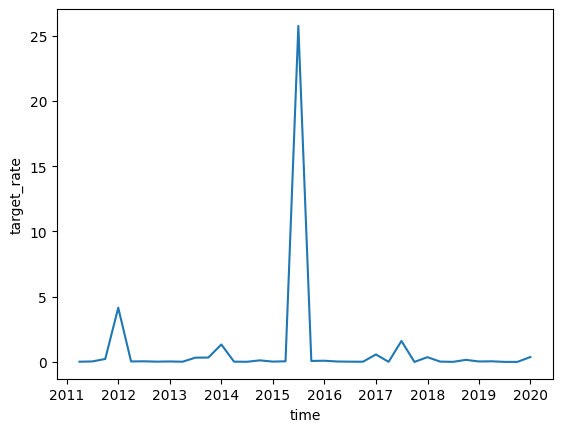

In [112]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

regr = MultiOutputRegressor(
Ridge(alpha=0.4))
pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])
pipe.fit(X_train, y_train)
scores = []

for date in df.index.unique():
    test_idx = df.reset_index()[(df.reset_index()['index'] >= date) & (df.reset_index()[
        'index'] < date + pd.DateOffset(days=1))].index
    data = df.reset_index().loc[test_idx]
    
    scores.append(mean_squared_error(pipe.predict(data[feature_columns]), data[target_columns]))
    
plt.plot(df.index.unique(), scores)
plt.xlabel('time')
plt.ylabel('target_rate')